In [1]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
import gym
import matplotlib.pyplot as plt

import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

In [3]:
class SharedAdam(torch.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8,
            weight_decay=0):
        super(SharedAdam, self).__init__(params, lr=lr, betas=betas, eps=eps,
                weight_decay=weight_decay)

        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = torch.zeros(1)
                state['exp_avg'] = torch.zeros_like(p.data)
                state['exp_avg_sq'] = torch.zeros_like(p.data)

                state['step'].share_memory_()
                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, input_dims, n_actions, gamma=0.99):
        super(ActorCritic, self).__init__()

        self.gamma = gamma

        self.pi1 = nn.Linear(*input_dims, 128)
        self.v1 = nn.Linear(*input_dims, 128)
        self.pi = nn.Linear(128, n_actions)
        self.v = nn.Linear(128, 1)

        self.rewards = []
        self.actions = []
        self.states = []

    def remember(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def forward(self, state):
        pi1 = F.relu(self.pi1(state))
        v1 = F.relu(self.v1(state))

        pi = self.pi(pi1)
        v = self.v(v1)

        return pi, v

    def calc_R(self, done):
        states = torch.tensor(self.states, dtype=torch.float)
        _, v = self.forward(states)

        R = v[-1]*(1-int(done))

        batch_return = []
        for reward in self.rewards[::-1]:
            R = reward + self.gamma*R
            batch_return.append(R)
        batch_return.reverse()
        batch_return = torch.tensor(batch_return, dtype=torch.float)

        return batch_return

    def calc_loss(self, done):
        states = torch.tensor(self.states, dtype=torch.float)
        actions = torch.tensor(self.actions, dtype=torch.float)

        returns = self.calc_R(done)

        pi, values = self.forward(states)
        values = values.squeeze()
        critic_loss = (returns-values)**2

        probs = torch.softmax(pi, dim=1)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions)
        actor_loss = -log_probs*(returns-values)

        total_loss = (critic_loss + actor_loss).mean()
    
        return total_loss

    def choose_action(self, observation):
        state = torch.tensor([observation], dtype=torch.float)
        pi, v = self.forward(state)
        probs = torch.softmax(pi, dim=1)
        dist = Categorical(probs)
        action = dist.sample().numpy()[0]

        return action

In [5]:
episode_rewards=[]
class Agent(mp.Process):
    def __init__(self, global_actor_critic, optimizer, input_dims, n_actions, 
                gamma, lr, name, global_ep_idx, env_id):
        super(Agent, self).__init__()
        self.local_actor_critic = ActorCritic(input_dims, n_actions, gamma)
        self.global_actor_critic = global_actor_critic
        self.name = 'w%02i' % name
        self.episode_idx = global_ep_idx
        self.env = gym.make(env_id)
        self.optimizer = optimizer

    def run(self):
        t_step = 1
        while self.episode_idx.value < N_GAMES:
            done = False
            observation = self.env.reset()
            score = 0
            self.local_actor_critic.clear_memory()
            while not done:
                action = self.local_actor_critic.choose_action(observation)
                observation_, reward, done, info = self.env.step(action)
                score += reward
                self.local_actor_critic.remember(observation, action, reward)
                if t_step % T_MAX == 0 or done:
                    loss = self.local_actor_critic.calc_loss(done)
                    self.optimizer.zero_grad()
                    loss.backward()
                    for local_param, global_param in zip(
                            self.local_actor_critic.parameters(),
                            self.global_actor_critic.parameters()):
                        global_param._grad = local_param.grad
                    self.optimizer.step()
                    self.local_actor_critic.load_state_dict(
                            self.global_actor_critic.state_dict())
                    self.local_actor_critic.clear_memory()
                t_step += 1
                observation = observation_
            with self.episode_idx.get_lock():
                self.episode_idx.value += 1
            print(self.name, 'episode ', self.episode_idx.value, 'reward %.1f' % score,'\n')
            episode_rewards.append(score)
        plt.plot(list(range(len(episode_rewards))), episode_rewards)
        plt.title('Episode Rewards over Time')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.show()

In [8]:
from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Streaming output truncated to the last 5000 lines.
w00 episode  w01250  reward 8.0episode  
 
251 reward 9.0 

w00 episode  252w01  reward 9.0episode   

253 reward 10.0 w00

 episode  254 w01reward 9.0 episode  255  reward 9.0 



w00w01  episode  256 reward 9.0 

episode  257w00 episode  258 reward 8.0 

 reward 9.0 

w00 episode  w01259 reward 11.0 

 episode  260 reward 9.0w00  
episode  261 reward 10.0 


w00w01  episode episode   262263 reward 8.0 
 
 
reward 10.0
w01w00 episode   265episode  264  reward 10.0reward 9.0 
 


w00 episode  w01 episode 266 267  reward 9.0 
reward 10.0
 

w01 w00 episode  269episode   reward 10.0 268 

reward 8.0 

w00 episode  w01270 episode  271 reward 9.0 

 reward 9.0 

w01 episode  272 reward 9.0 

w00 w01episode  episode  274 reward 9.0  
273
 reward 10.0 

w01 episode w00 275reward 10.0  

 episode  276w01  reward 10.0 episode 
 
277 reward 11.0 

w00 episode  278 reward 9.0w01 
 
episode  279w00  episode reward 10.0  
280
 reward 9.0 

w01 epi

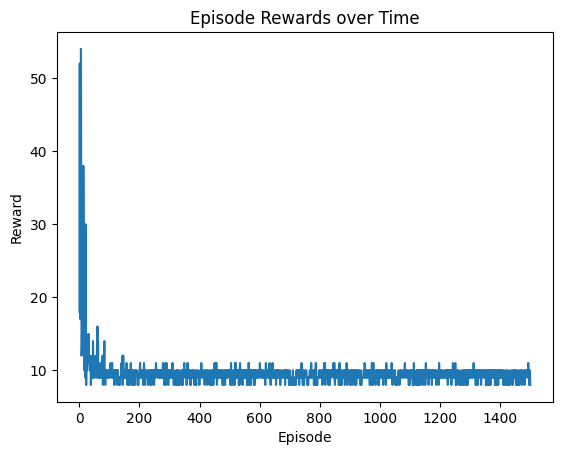

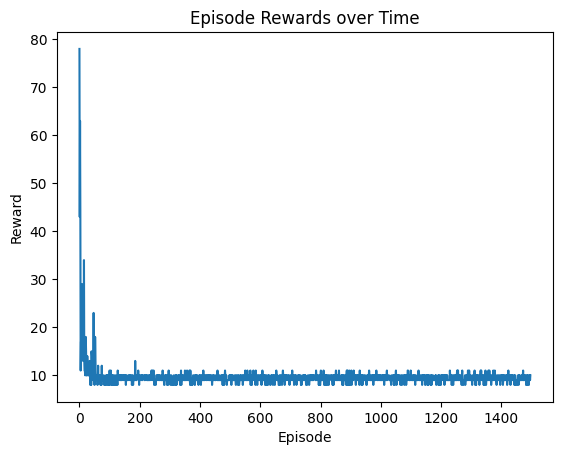

[None, None]

In [11]:
lr = 1e-4
env_id = 'CartPole-v0'
n_actions = 2
input_dims = [4]
N_GAMES = 3000
T_MAX = 5
global_actor_critic = ActorCritic(input_dims, n_actions)
global_actor_critic.share_memory()
optim = SharedAdam(global_actor_critic.parameters(), lr=lr, 
                        betas=(0.92, 0.999))
global_ep = mp.Value('i', 0)

workers = [Agent(global_actor_critic,
                    optim,
                    input_dims,
                    n_actions,
                    gamma=0.99,
                    lr=lr,
                    name=i,
                    global_ep_idx=global_ep,
                    env_id=env_id) for i in range(mp.cpu_count())]
[w.start() for w in workers]
[w.join() for w in workers]